In [1]:
import os
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "langchain-academy"

## Define graph

In [2]:
from langchain_openai import ChatOpenAI

def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

# This will be a tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

def divide(a: int, b: int) -> float:
    """Divide a and b.

    Args:
        a: first int
        b: second int
    """
    return a / b


tools = [add, multiply, divide]
llm: ChatOpenAI = ChatOpenAI(
    base_url="http://127.0.0.1:1234/v1",
    temperature=0,
    api_key="not-needed"
)
llm_with_tools = llm.bind_tools(tools ,parallel_tool_calls=False)

In [3]:
from langgraph.graph import MessagesState
from langchain_core.messages import HumanMessage, SystemMessage

# System message
sys_msg = SystemMessage(
    content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")

# Node
def assistant(state: MessagesState):
    return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

We connect the Tools node back to the Assistant, forming a loop.

- After the assistant node executes, tools_condition checks if the model's output is a tool call.
- If it is a tool call, the flow is directed to the tools node.
- The tools node connects back to assistant.
- This loop continues as long as the model decides to call tools.
- If the model response is not a tool call, the flow is directed to END, terminating the process.

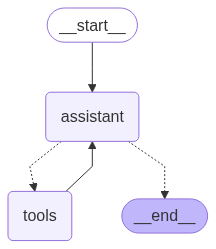

In [4]:
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition
from langgraph.prebuilt import ToolNode
from IPython.display import Image, display

builder = StateGraph(MessagesState)
# Defines nodes: these do the work
builder.add_node(assistant)
builder.add_node("tools", ToolNode(tools))

# Define edges: these determine how the control flow moves
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)

builder.add_edge("tools", "assistant")
react_graph = builder.compile()

display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

## Memory

In [ ]:
messages = [HumanMessage(content="Add 3 and 4.")]
messages = react_graph.invoke({"messages": messages})
for m in messages['messages']:
    m.pretty_print()

d:\Asus\Ungdung\Miniconda\workspace\envs\LLMs_Agents\lib\site-packages\langsmith\client.py:272: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(
Failed to multipart ingest runs: langsmith.utils.LangSmithAuthError: Authentication failed for https://api.smith.langchain.com/runs/multipart. HTTPError('401 Client Error: Unauthorized for url: https://api.smith.langchain.com/runs/multipart', '{"error":"Unauthorized"}\n')trace=debd198e-7ad3-4a2c-9520-da71a10d8d56,id=debd198e-7ad3-4a2c-9520-da71a10d8d56
Failed to send compressed multipart ingest: langsmith.utils.LangSmithAuthError: Authentication failed for https://api.smith.langchain.com/runs/multipart. HTTPError('401 Client Error: Unauthorized for url: https://api.smith.langchain.com/runs/multipart', '{"error":"Unauthorized"}\n')trace=debd198e-7ad3-4a2c-9520-da71a10d8d56,id=f341d005-e0f9-48c9-ba3a-11f7caa08319; trace=debd198e-7ad3-4a2c-9520-da71a10d8d56,id=34221c2c-9b81-4b50-bd56-ae2ccfb

================================ Human Message =================================

Add 3 and 4.
================================== Ai Message ==================================
Tool Calls:
  add (243548163)
 Call ID: 243548163
  Args:
    a: 3
    b: 4
================================= Tool Message =================================
Name: add

7
================================== Ai Message ==================================

<think>
Okay, the user asked to add 3 and 4. I used the add function with a=3 and b=4. The result was 7. Now I need to confirm that the answer is correct. 3 plus 4 equals 7, so yes, that's right. I should present the final answer as 7.
</think>

The result of adding 3 and 4 is **7**.


Failed to send compressed multipart ingest: langsmith.utils.LangSmithAuthError: Authentication failed for https://api.smith.langchain.com/runs/multipart. HTTPError('401 Client Error: Unauthorized for url: https://api.smith.langchain.com/runs/multipart', '{"error":"Unauthorized"}\n')trace=debd198e-7ad3-4a2c-9520-da71a10d8d56,id=978c11c4-1e42-4318-b83b-bf2d275e2f5d; trace=debd198e-7ad3-4a2c-9520-da71a10d8d56,id=1561c91b-2b62-4bb7-8029-08e2c9585c4e; trace=debd198e-7ad3-4a2c-9520-da71a10d8d56,id=1561c91b-2b62-4bb7-8029-08e2c9585c4e; trace=debd198e-7ad3-4a2c-9520-da71a10d8d56,id=1ec89a16-c56a-40fa-8edd-cf1cb4fd60e7; trace=debd198e-7ad3-4a2c-9520-da71a10d8d56,id=debd198e-7ad3-4a2c-9520-da71a10d8d56; trace=371f038b-3994-476b-8102-277dccff169f,id=371f038b-3994-476b-8102-277dccff169f; trace=371f038b-3994-476b-8102-277dccff169f,id=080b2628-ee19-45b1-a20f-5e63eea69873; trace=371f038b-3994-476b-8102-277dccff169f,id=0f87c058-e94a-42c9-94c1-32dda28d19e8
Failed to send compressed multipart ingest: la

In [6]:
messages = [HumanMessage(content="Multiply that by 2.")]
messages = react_graph.invoke({"messages": messages})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Multiply that by 2.
================================== Ai Message ==================================

<think>
Okay, let's see. The user said "Multiply that by 2." Hmm, first I need to understand what "that" refers to. But wait, the context isn't provided here. Maybe there was a previous interaction where "that" was mentioned? Since this is a standalone query, perhaps there's missing information.

Wait, maybe the user is referring to a previous calculation. But in the current prompt, there's no prior history. So without knowing what "that" refers to, I can't proceed. The functions available are add, multiply, and divide. However, the user's instruction is ambiguous because "that" isn't specified.

I should check if there's any implicit context. For example, if "that" was mentioned in a previous step, but since this is a new query, maybe it's a mistake or missing information. The user might have intended to

In [ ]:
from langgraph.checkpoint.memory import MemorySaver
memory = MemorySaver()
react_graph_memory = builder.compile(checkpointer=memory)